# Korean Hate Speech Classifier
## Written by: [Jehwan Kim](github.com/kreimben)
## Date: 19th Feb 2024
## Referenced Paper: 
* [Convolutional Neural Networks for Sentence Classification](https://arxiv.org/abs/1408.5882)
* [Cyclical Learning Rates for Training Neural Networks](https://arxiv.org/abs/1506.01186)

### Load the word2vec model first,

In [1]:
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import TensorDataset, DataLoader


%matplotlib inline

### And then, load labeled data using pandas

In [2]:
dev_df = pd.read_csv('./labeled/dev.tsv', sep='\t')
train_df = pd.read_csv('./labeled/train.tsv', sep='\t')

In [3]:
train_df.head()

,comments,contain_gender_bias,bias,hate
0,(현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...,False,others,hate
1,....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...,False,none,none
2,"...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...",False,none,hate
3,"1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데",False,none,none
4,1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...,True,gender,hate


In [4]:
dev_df.head()

,comments,contain_gender_bias,bias,hate
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,False,none,none
1,지현우 나쁜놈,False,none,offensive
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,False,none,hate
3,설마 ㅈ 현정 작가 아니지??,True,gender,hate
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,False,none,offensive


### In `hate` column, `offensive`, `none`, `hate`.
### In `contain_gender_bias` column, `True`, `False`.
### In `bias` column, `none`, `gender`, `others`.

In [5]:
# combine train and dev data.
df = pd.concat([dev_df, train_df], ignore_index=True)
df.sample(5)

,comments,contain_gender_bias,bias,hate
3563,부동산 업자의 알았을거다.이 한마디에 대성 평생 이룬 커리어를 무너트릴려고? 생각좀...,False,none,hate
1773,꼭 트와 찐팬 아닌것들이 맨날 더 광분하더라 ㅉ,False,others,offensive
5271,역겨워. 더러워. 저번에 걸렸을때 수사만 제대로 했으면 다음 피해자는 없었을텐데.....,False,others,hate
7477,진짜 이쁘긴 이쁘다,False,none,none
1477,근데 어쩔??,False,none,offensive


In [6]:
df.hate.value_counts(), dev_df.contain_gender_bias.value_counts(), dev_df.bias.value_counts()

(hate
 none         3646
 offensive    2688
 hate         2033
 Name: count, dtype: int64,
 contain_gender_bias
 False    404
 True      67
 Name: count, dtype: int64,
 bias
 none      342
 gender     67
 others     62
 Name: count, dtype: int64)

### Load words data and tokeniser from past project.

In [7]:
import pickle

with open('tokenizer.pkl', 'rb') as handle:
    tokenizer = pickle.load(handle)

with open('words.pkl', 'rb') as handle:
    words = pickle.load(handle)

In [8]:



def tokenize(sentence):
    tokens = tokenizer.tokenize(sentence)
    preprocess = lambda x: [w for w in x if w not in STOP_WORDS]
    return preprocess(tokens)

In [9]:
sample = df.sample(1).comments.values[0]

sample, tokenize(sample)

('미애가 이쁘긴해', ['미애', '이쁘긴', '해'])

In [10]:
df['tokens'] = df['comments'].apply(tokenize)
# 공격적인(offensive) 댓글 또한 혐오 데이터 셋으로 분류함.
df['hate'] = df['hate'].replace(['none', 'offensive', 'hate'], [0, 1, 1])
df['contain_gender_bias'] = df['contain_gender_bias'].replace([True, False], [1, 0])
df.head()

/var/folders/yk/hzm_ywr95w3gr1cvnlndq5_r0000gn/T/ipykernel_96054/1445675357.py:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['hate'] = df['hate'].replace(['none', 'offensive', 'hate'], [0, 1, 1])
/var/folders/yk/hzm_ywr95w3gr1cvnlndq5_r0000gn/T/ipykernel_96054/1445675357.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['contain_gender_bias'] = df['contain_gender_bias'].replace([True, False], [1, 0])


,comments,contain_gender_bias,bias,hate,tokens
0,송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.,0,none,0,"[송중기, 시대, 극은, 믿고, 본다., 첫회, 신선, 았다, .]"
1,지현우 나쁜놈,0,none,1,"[지현우, 나쁜놈]"
2,알바쓰고많이만들면되지 돈욕심없으면골목식당왜나온겨 기댕기게나하고 산에가서팔어라,0,none,1,"[알바, 쓰고, 많이, 만들면, 되지, 돈, 욕심, 으면, 골목, 식당, 왜나온겨,..."
3,설마 ㅈ 현정 작가 아니지??,1,gender,1,"[ㅈ, 현정, 작가, ??]"
4,이미자씨 송혜교씨 돈이 그리 많으면 탈세말고 그돈으로 평소에 불우이웃에게 기부도 좀...,0,none,1,"[이미자, 송혜교, 돈이, 그리, 으면, 탈세, 말고, 그돈, 평소, 불우이웃, 기..."


In [11]:
vocab = set()
for sentence in df.tokens:
    for word in sentence: vocab.add(word)

vocab_size = len(vocab)

### Vectorise

In [12]:
with open('vectorizer.pkl', 'rb') as handle:
    vectorizer = pickle.load(handle)

### Encoding

In [13]:
df['encoding'] = df['comments'].apply(vectorizer.encode_a_doc_to_list)
df.encoding

0         [13834, 366, 55661, 671, 1342, 16079, 423, 432]
1                                                  [6021]
2       [750, 384, 2886, 332, 1898, 10604, 3279, 21690...
3                               [1990, 1092, 75890, 9257]
4       [84631, 533, 15596, 533, 454, 171, 779, 5641, ...
                              ...                        
8362                                        [2805, 11384]
8363                       [2805, 7442, 3105, 3781, 3744]
8364              [46019, 1577, 58, 591, 1505, 22957, 58]
8365    [4232, 882, 75943, 769, 4678, 887, 22943, 4270...
8366       [396, 1469, 1727, 36544, 1694, 30, 3644, 5144]
Name: encoding, Length: 8367, dtype: object

In [14]:
X_data = df['encoding']
y_data = df['hate']
print(y_data.value_counts())
len(X_data), len(y_data), len(X_data) == len(y_data)

hate
1    4721
0    3646
Name: count, dtype: int64


(8367, 8367, True)

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=.1, random_state=0, stratify=y_data)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=.1, random_state=0, stratify=y_train)

y_train.value_counts()

hate
1    3824
0    2953
Name: count, dtype: int64

In [16]:
print('공격적인(offensive) 댓글 또한 혐오 데이터 셋으로 분류함.')
print('--------훈련 데이터의 비율-----------')
print(f'혐오 댓글 = {round(y_train.value_counts()[1] / len(y_train) * 100, 3)}%')
print(f'일반 댓글 = {round(y_train.value_counts()[0] / len(y_train) * 100, 3)}%')
print('--------검증 데이터의 비율-----------')
print(f'혐오 댓글 = {round(y_valid.value_counts()[1] / len(y_valid) * 100, 3)}%')
print(f'일반 댓글 = {round(y_valid.value_counts()[0] / len(y_valid) * 100, 3)}%')
print('--------테스트 데이터의 비율-----------')
print(f'혐오 댓글 = {round(y_test.value_counts()[1] / len(y_test) * 100, 3)}%')
print(f'일반 댓글 = {round(y_test.value_counts()[0] / len(y_test) * 100, 3)}%')

공격적인(offensive) 댓글 또한 혐오 데이터 셋으로 분류함.
--------훈련 데이터의 비율-----------
혐오 댓글 = 56.426%
일반 댓글 = 43.574%
--------검증 데이터의 비율-----------
혐오 댓글 = 56.441%
일반 댓글 = 43.559%
--------테스트 데이터의 비율-----------
혐오 댓글 = 56.392%
일반 댓글 = 43.608%


### Padding

댓글의 최대 길이 : 39
댓글의 평균 길이 : 9.449018739855394


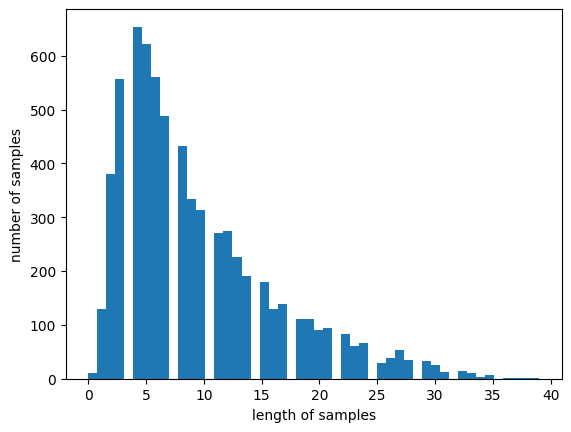

In [17]:
print('댓글의 최대 길이 :', max(len(review) for review in X_train))
print('댓글의 평균 길이 :', sum(map(len, X_train)) / len(X_train))
plt.hist([len(review) for review in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [18]:
max_len = max(len(review) for review in X_train)

### 길이가 길지 않아서 그냥 최대값 그대로 진행합니다. (패딩)

In [19]:
def pad_sequences(sentences: [[int]], max_len: int) -> np.ndarray:
    features = np.zeros((len(sentences), max_len), dtype=int)
    for index, sentence in enumerate(sentences):
        if len(sentence) != 0:
            features[index, :len(sentence)] = np.array(sentence)[:max_len]
    return features

In [20]:
padded_X_train = pad_sequences(X_train, max_len=max_len)
padded_X_valid = pad_sequences(X_valid, max_len=max_len)
padded_X_test = pad_sequences(X_test, max_len=max_len)

print('훈련 데이터의 크기 :', padded_X_train.shape)
print('검증 데이터의 크기 :', padded_X_valid.shape)
print('테스트 데이터의 크기 :', padded_X_test.shape)

훈련 데이터의 크기 : (6777, 39)
검증 데이터의 크기 : (753, 39)
테스트 데이터의 크기 : (837, 39)


In [21]:
padded_X_test[:5, :]

array([[   134,   1488,   1208,  45102,  43648,   1988,  18220,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [  1224,      0,     33,    663,    122,   2622,   2151,  42010,
          3199,  25792,   1369,   9438,  26509,   9196,  37384,  11499,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0],
       [ 71953,   2929,   5341,   8097,    614,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
             0,      0,      0,      0,      0,      0,      0,      0,
      

### Modeling

In [22]:
train_label_tensor = torch.tensor(np.array(y_train))
valid_label_tensor = torch.tensor(np.array(y_valid))
test_label_tensor = torch.tensor(np.array(y_test))
print(train_label_tensor[:5])

tensor([1, 1, 0, 1, 1])


In [23]:
class TextCNNLightning(L.LightningModule):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, dropout, train_batch_size):
        super().__init__()
        self.lr = None
        self.train_batch_size = train_batch_size
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels=1, out_channels=n_filters, kernel_size=(fs, embedding_dim))
            for fs in filter_sizes
        ])
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, text):
        # text = [batch size, sent len]
        embedded = self.embedding(text)  # embedded = [batch size, sent len, emb dim]
        embedded = embedded.unsqueeze(1)  # embedded = [batch size, 1, sent len, emb dim]
        conved = [F.relu(conv(embedded)).squeeze(3) for conv in self.convs]
        # conv_n = [batch size, n_filters, sent len - filter_sizes[n]]
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        # pooled_n = [batch size, n_filters]
        cat = self.dropout(torch.cat(pooled, dim=1))
        # cat = [batch size, n_filters * len(filter_sizes)]
        return self.fc(cat)

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters())

    def training_step(self, batch, batch_idx):
        # Get inputs and labels
        inputs, labels = batch

        # Forward pass
        outputs = self(inputs)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Log loss
        self.log("train_loss", loss)

        # Return loss
        return loss

    def __accuracy(self, outputs, labels):
        predictions = outputs.argmax(dim=1)  # Get indices of highest probability
        correct = (predictions == labels).sum().item()
        acc = correct / len(labels)
        return acc

    def validation_step(self, batch, batch_idx):
        # Get inputs and labels
        inputs, labels = batch

        # Forward pass
        outputs = self(inputs)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Calculate accuracy
        acc = self.__accuracy(outputs, labels)

        # Log loss and accuracy
        self.log("val_loss", loss)
        self.log("val_acc", acc)

        # Return loss and accuracy
        return loss, acc

    def test_step(self, batch, batch_idx):
        # Get inputs and labels
        inputs, labels = batch

        # Forward pass
        outputs = self(inputs)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Calculate accuracy
        acc = self.__accuracy(outputs, labels)

        # Log loss and accuracy
        self.log("test_loss", loss)
        self.log("test_acc", acc)

        # Return loss and accuracy
        return loss, acc

    def train_dataloader(self):
        encoded_train = torch.tensor(padded_X_train).to(torch.int32)
        train_dataset = TensorDataset(encoded_train, train_label_tensor)
        train_dataloader = DataLoader(train_dataset, shuffle=True, num_workers=7,
                                      persistent_workers=True, batch_size=self.train_batch_size)
        return train_dataloader

    def val_dataloader(self):
        encoded_valid = torch.tensor(padded_X_valid).to(torch.int32)
        valid_dataset = TensorDataset(encoded_valid, valid_label_tensor)
        valid_dataloader = DataLoader(valid_dataset, shuffle=False, batch_size=1, num_workers=7,
                                      persistent_workers=True)
        return valid_dataloader

    def test_dataloader(self):
        encoded_test = torch.tensor(padded_X_test).to(torch.int32)
        test_dataset = TensorDataset(encoded_test, test_label_tensor)
        test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1, num_workers=7)
        return test_dataloader

In [24]:
# # HPO using optuna
# 
# def objective(trial):
#     # Define the hyperparameter space
#     embedding_dim = trial.suggest_int("embedding_dim", 100, 500)
#     n_filters = trial.suggest_int("n_filters", 100, 300)
#     dropout_rate = trial.suggest_float('dropout_rate', .1, .9)
# 
#     # Suggest a logarithmic value
#     log_base_2_value = trial.suggest_int('log_base_2_value', 0, 10)
#     # Convert to actual value
#     train_batch_size = 2 ** log_base_2_value
# 
#     # Initialize the model with the hyperparameters
#     model = TextCNNLightning(vocab_size=vocab_size, embedding_dim=embedding_dim, n_filters=n_filters,
#                              filter_sizes=[3, 4, 5], output_dim=2, dropout=dropout_rate,
#                              train_batch_size=train_batch_size)
# 
#     # Trainer settings
#     trainer = L.Trainer(
#         accelerator="auto", max_epochs=15
#     )
# 
#     # Train the model
#     trainer.fit(model)
# 
#     # Evaluate the model performance
#     return trainer.callback_metrics["train_loss"]


In [25]:
# import optuna
# 
# # Create a study object
# study = optuna.create_study()  # or 'maximize' based on your goal
# study.optimize(objective, n_trials=100)  # Specify the number of trials
# 
# # Print the best hyperparameters
# print(f"Best trial: {study.best_trial.params}")


In [26]:
# model = TextCNNLightning(vocab_size=vocab_size, num_labels=len(set(y_train)), l=l)
model = TextCNNLightning(vocab_size=vocab_size, embedding_dim=300, n_filters=100,
                         filter_sizes=[3, 4, 5], output_dim=2, dropout=.5, train_batch_size=512)

vocab_size, len(set(y_train))

(24423, 2)

### Train

In [27]:
%%time

from lightning.pytorch.callbacks import LearningRateFinder

trainer = L.Trainer(
    accelerator="auto", devices="auto", strategy="auto",
    max_epochs=10, callbacks=[LearningRateFinder()]
)
trainer.fit(model=model)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/kreimben/Repository/KoreanHateSpeechClassifier/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
Missing logger folder: /Users/kreimben/Repository/KoreanHateSpeechClassifier/lightning_logs
/Users/kreimben/Repository/KoreanHateSpeechClassifier/venv/lib/python3.10/site-packages/lightning/pytorch/loops/fit_loop.py:298: The number of training batches (14) is smaller than the 

Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

LR finder stopped early after 91 steps due to diverging loss.
Learning rate set to 0.006918309709189364
Restoring states from the checkpoint path at /Users/kreimben/Repository/KoreanHateSpeechClassifier/.lr_find_7181f8c8-18a4-4bbe-a70c-3f9eb0d5b1c3.ckpt
Restored all states from the checkpoint at /Users/kreimben/Repository/KoreanHateSpeechClassifier/.lr_find_7181f8c8-18a4-4bbe-a70c-3f9eb0d5b1c3.ckpt

  | Name      | Type       | Params
-----------------------------------------
0 | embedding | Embedding  | 7.3 M 
1 | convs     | ModuleList | 360 K 
2 | fc        | Linear     | 602   
3 | dropout   | Dropout    | 0     
-----------------------------------------
7.7 M     Trainable params
0         Non-trainable params
7.7 M     Total params
30.751    Total estimated model params size (MB)
Restored all states from the checkpoint at /Users/kreimben/Repository/KoreanHateSpeechClassifier/.lr_find_7181f8c8-18a4-4bbe-a70c-3f9eb0d5b1c3.ckpt


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


CPU times: user 25.2 s, sys: 7.27 s, total: 32.5 s
Wall time: 1h 45min 58s


In [28]:
trainer.test()

/Users/kreimben/Repository/KoreanHateSpeechClassifier/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /Users/kreimben/Repository/KoreanHateSpeechClassifier/lightning_logs/version_0/checkpoints/epoch=9-step=133.ckpt
Loaded model weights from the checkpoint at /Users/kreimben/Repository/KoreanHateSpeechClassifier/lightning_logs/version_0/checkpoints/epoch=9-step=133.ckpt
/Users/kreimben/Repository/KoreanHateSpeechClassifier/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:436: Consider setting `persistent_workers=True` in 'test_dataloader' to speed up the dataloader worker initializati

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6463560461997986
        test_loss           0.7093809247016907
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7093809247016907, 'test_acc': 0.6463560461997986}]

### Using Bert to classificate

In [119]:
from icecream import ic
from utils.evaluate import calculate_accuracy
from transformers import BertModel


class BertClassifier(L.LightningModule):
    def __init__(self, n_classes: int, pretrained_model_name="klue/bert-base", steps_per_epoch=None, n_epochs=None, batch_size=32):
        super().__init__()
        self.batch_size = batch_size
        self.bert = BertModel.from_pretrained(pretrained_model_name)
        self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
        self.criterion = nn.CrossEntropyLoss()
        self.steps_per_epoch = steps_per_epoch
        self.n_epochs = n_epochs
        self.save_hyperparameters()

    def forward(self, input_ids, attention_mask):
        output = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        return self.classifier(output.pooler_output)

    def training_step(self, batch, batch_idx):
        input_ids, attention_mask, labels = batch
        
        input_ids = input_ids.reshape(-1, input_ids.shape[-1])  # Keep last dimension dynamic
        attention_mask = attention_mask.reshape(-1, attention_mask.shape[-1])
        
        outputs = self(input_ids, attention_mask)
        loss = self.criterion(outputs, labels)
        self.log("train_loss", loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        # Get inputs and labels
        input_ids, attention_mask, labels = batch
        
        input_ids = input_ids.reshape(-1, input_ids.shape[-1])  # Keep last dimension dynamic
        attention_mask = attention_mask.reshape(-1, attention_mask.shape[-1])

        # Forward pass
        outputs = self(input_ids, attention_mask)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Calculate accuracy
        acc = calculate_accuracy(outputs, labels)

        # Log loss and accuracy
        self.log("val_loss", loss)
        self.log("val_acc", acc)

        # Return loss and accuracy
        return loss, acc

    def test_step(self, batch, batch_idx):
        # Get inputs and labels
        input_ids, attention_mask, labels = batch

        # Forward pass
        outputs = self(input_ids, attention_mask)

        # Calculate loss
        loss = F.cross_entropy(outputs, labels)

        # Calculate accuracy
        acc = calculate_accuracy(outputs, labels)

        # Log loss and accuracy
        self.log("test_loss", loss)
        self.log("test_acc", acc)

        # Return loss and accuracy
        return loss, acc

    def configure_optimizers(self):
        optimizer = torch.optim.AdamW(self.parameters(), lr=2e-5)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=self.steps_per_epoch * 0.1, gamma=0.1)
        return [optimizer], [scheduler]

In [122]:
from sklearn.model_selection import train_test_split
from utils.stopwords import STOP_WORDS

dev_df = pd.read_csv('./labeled/dev.tsv', sep='\t')
train_df = pd.read_csv('./labeled/train.tsv', sep='\t')
df = pd.concat([dev_df, train_df], ignore_index=True)

from torch.utils.data import random_split
from transformers import BertTokenizer

bert_model = BertModel.from_pretrained("klue/bert-base")
tokenizer = BertTokenizer.from_pretrained('klue/bert-base')

tokenized_batch = tokenizer.batch_encode_plus(df.comments.values, padding=True, truncation=True, return_tensors='pt')

input_ids = tokenized_batch['input_ids']
attention_mask = tokenized_batch['attention_mask']
y_label_tensor = torch.tensor(np.array(y_data))

dataset = TensorDataset(input_ids, attention_mask, y_label_tensor)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])
train_dataloader, val_dataloader, test_dataloader = DataLoader(train_set, batch_size=32, shuffle=True), DataLoader(val_set, batch_size=32), DataLoader(test_set, batch_size=32)

vocab_size = tokenizer.vocab_size

In [123]:
# 모델 인스턴스화 및 훈련 파라미터 설정
bert_classifier_model = BertClassifier(n_classes=2, steps_per_epoch=100, n_epochs=3)

# 트레이너 설정 및 훈련 시작
bert_trainer = L.Trainer(max_epochs=3)
bert_trainer.fit(bert_classifier_model, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name       | Type             | Params
------------------------------------------------
0 | bert       | BertModel        | 110 M 
1 | classifier | Linear           | 1.5 K 
2 | criterion  | CrossEntropyLoss | 0     
------------------------------------------------
110 M     Trainable params
0         Non-trainable params
110 M     Total params
442.476   Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/kreimben/Repository/KoreanHateSpeechClassifier/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
/Users/kreimben/Repository/KoreanHateSpeechClassifier/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [125]:
bert_trainer.test(dataloaders=[test_dataloader])

/Users/kreimben/Repository/KoreanHateSpeechClassifier/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/checkpoint_connector.py:145: `.test(ckpt_path=None)` was called without a model. The best model of the previous `fit` call will be used. You can pass `.test(ckpt_path='best')` to use the best model or `.test(ckpt_path='last')` to use the last model. If you pass a value, this warning will be silenced.
Restoring states from the checkpoint path at /Users/kreimben/Repository/KoreanHateSpeechClassifier/lightning_logs/version_16/checkpoints/epoch=2-step=549.ckpt
Loaded model weights from the checkpoint at /Users/kreimben/Repository/KoreanHateSpeechClassifier/lightning_logs/version_16/checkpoints/epoch=2-step=549.ckpt
/Users/kreimben/Repository/KoreanHateSpeechClassifier/venv/lib/python3.10/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:441: The 'test_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7778662443161011
        test_loss           0.7982401847839355
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.7982401847839355, 'test_acc': 0.7778662443161011}]

# 최종 결과

* 이전 프로젝트인 word2vec에서 직접 가져온 tokeniser로 단어 임베딩을 진행한 결과 
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.6463560461997986
        test_loss           0.7093809247016907
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
정확도는 64%이고 손실률은 0.7이 됐다.
손수 직접 임베딩을 한 것이라, 아무리 epoch를 더 돌린다 해도 정확도가 더 올라가지 않아 포기했다.
HPO 관련 라이브러리를 설치해봤으나 시간이 너무 부족해 hpo는 하지 못했다.

* bert에서 가져온 tokeniser로 단어 임베딜을 진행한 결과
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7778662443161011
        test_loss           0.7982401847839355
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
정확도는 77%이고 손실률은 0.79이다.

---

프로젝트를 진행하면서 의문이였던 점은, 'tokeniser의 차이로 문장들의 전체 길이가 달라진다는 점이 최종 결과까지 영향을 줄 수 있는가'이다.
또한 '이모티콘이나 자음을 이용해 ㅇㅁㅇ 이나 (ㅇㅅㅇ) 와 같은 것을 쓴다면 이 역시 stopword나 정규식을 이용해 필터링 해야하는가'이다.
한국인들은 ㅋ 와 ㅋㅋ 의 의미를 다르게 받아들인다. 이럴 경우 tokenising 처리를 어디까지 해줘야 하는지가 관건인것 같다. 